In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings('ignore')

### 1. download and then load the CIFAR10 data

In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# part to be training and part to be validation
train_set, valid_set = torch.utils.data.random_split(trainset, [45000, 5000], generator=torch.Generator().manual_seed(42))
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### visualize some of the training datas 

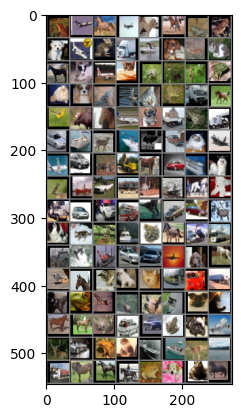

frog  plane horse plane dog   horse frog  frog  dog   plane cat   truck ship  dog   deer  cat   horse dog   plane cat   frog  cat   deer  frog  cat   dog   plane bird  cat   frog  truck horse bird  deer  horse plane dog   truck frog  truck car   ship  deer  ship  bird  car   cat   plane plane car   deer  truck horse car   ship  dog   bird  ship  car   plane bird  plane horse dog   truck car   car   truck dog   car   car   deer  dog   cat   deer  ship  frog  horse truck truck ship  cat   ship  car   car   plane dog   horse bird  horse cat   dog   cat   truck car   truck cat   frog  plane deer  deer  cat   dog   cat   horse horse frog  car   car   frog  dog   plane deer  car   frog  cat   ship  ship  deer  ship  truck horse horse horse frog  dog   frog  horse


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
since this part we train from pretrained on ImageNet, so the model parameter 'weights' is set to be 'True'

In [4]:
import torch
import torchvision.models as models

resnet18 = models.resnet18(weights=True)
resnet34 = models.resnet34(weights=True)
resnet50 = models.resnet50(weights=True)
resnet101 = models.resnet101(weights=True)
resnet152 = models.resnet152(weights=True)

nets = [resnet18, resnet34, resnet50, resnet101, resnet152]
for net in nets:
    net.fc = torch.nn.Linear(net.fc.in_features, 10) # the CIFAR10 dataset has 10 classes
    net = net.to('cuda')

### 3. Define a Loss function and optimizer

In [5]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizers = [optim.SGD(net.parameters(), lr=0.1, momentum=0.9) for net in nets]

# some settings
train_num = len(train_set)
valid_num = len(valid_set)
test_num = len(testset)
train_batch_num = len(trainloader)
valid_batch_num = len(validloader)
test_batch_num = len(testloader)

### 4. the function that calculate the current prediction accuracy on training dataset


In [6]:
def eval_accuracy(net, depth):

    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy
    # print(f'Accuracy on the test set of model ResNet{depth}: {accuracy}%')

### 5. Train the network

In [8]:
import tqdm

net_depths = [18, 34, 50, 101, 152]
epochs = 200

training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []

for net_num, net in enumerate(nets):
    optimizer = optimizers[net_num]
    depth = net_depths[net_num]

    iter = 0
    iterations = []
    train_all_loss = []
    train_all_acc = []
    valid_all_loss = []
    valid_all_acc = []
    learning_rate = 0.1

    with open(f'./info/ResNet_finetune.txt', 'a') as f:
        f.write("=========================================================\n")     
        f.write(f'start training ResNet{depth}\n')   

    for epoch in range(epochs):  # loop over the dataset multiple times
        # print(f'Epoch {epoch + 1}')
        net.train()
        total_loss = 0.0
        total_correct = 0

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            total_loss += loss.item()
            total_correct += (outputs.argmax(axis=1) == labels).sum().item()
            iter += 1

            if iter == 32000:
                learning_rate /= 10
                optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
            elif iter == 48000:
                learning_rate /= 10
                optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

        train_loss = total_loss / batch_size
        train_acc = total_correct / train_num
        train_all_loss.append(train_loss)
        train_all_acc.append(train_acc)
        iterations.append(iter)

        net.eval()
        total_loss = 0.0
        total_correct = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(validloader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = inputs.to('cuda'), labels.to('cuda')

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                # print statistics
                total_loss += loss.item()
                total_correct += (outputs.argmax(axis=1) == labels).sum().item()

        valid_loss = total_loss / valid_batch_num
        valid_acc = total_correct / valid_num

        valid_all_loss.append(valid_loss)
        valid_all_acc.append(valid_acc)

        with open(f'./info/ResNet_finetune.txt', 'a') as f:
            f.write(f'Epoch {epoch + 1}, iteration {iter}, train loss: {train_loss:.4f}, valid loss: {valid_loss:.4f}, train acc: {train_acc:.4f}, valid acc: {valid_acc:.4f}\n')
        # print("Epoch {}, iteration {}, train loss: {:.4f}, valid loss: {:.4f}, train acc: {:.4f}, valid acc: {:.4f}".format(epoch, iter, train_loss, val_loss, train_acc, val_acc))
    
    with open(f'./info/ResNet_finetune.txt', 'a') as f:
        f.write("=========================================================\n")
        f.write(f'finished training ResNet{depth}\n')

    training_accuracies.append(train_all_acc)
    training_losses.append(train_all_loss)
    validation_accuracies.append(valid_all_acc)
    validation_losses.append(valid_all_loss)

#### save the trained model that are pretrained

In [9]:
for i, net in enumerate(nets):
    PATH = f'./model_para/finetune/ResNet{net_depths[i]}.pth'
    torch.save(net.state_dict(), PATH)

# turn the lists into numpy arrays and save them
    training_losses_np = np.array(training_losses[i])
    training_accuracies_np = np.array(training_accuracies[i])
    validation_losses_np = np.array(validation_losses[i])
    validation_accuracies_np = np.array(validation_accuracies[i])
    
    np.save(f'./model_para/finetune/ResNet{net_depths[i]}_training_losses.npy', training_losses_np)
    np.save(f'./model_para/finetune/ResNet{net_depths[i]}_training_accuracies.npy', training_accuracies_np)
    np.save(f'./model_para/finetune/ResNet{net_depths[i]}_validation_losses.npy', validation_losses_np)
    np.save(f'./model_para/finetune/ResNet{net_depths[i]}_validation_accuracies.npy', validation_accuracies_np)

##### load the saved data after training when they are needed.

In [5]:
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []

net_depths = [152, 101, 50, 34, 18]

# load the .npy data

for depth in net_depths:
    training_loss = np.load(f'./model_para/finetune/ResNet{depth}_training_losses.npy').tolist()
    training_accuracy = np.load(f'./model_para/finetune/ResNet{depth}_training_accuracies.npy').tolist()
    validation_loss = np.load(f'./model_para/finetune/ResNet{depth}_validation_losses.npy').tolist()
    validation_accuracy = np.load(f'./model_para/finetune/ResNet{depth}_validation_accuracies.npy').tolist()

    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

### 6. plot the training loss and the accuracy figure

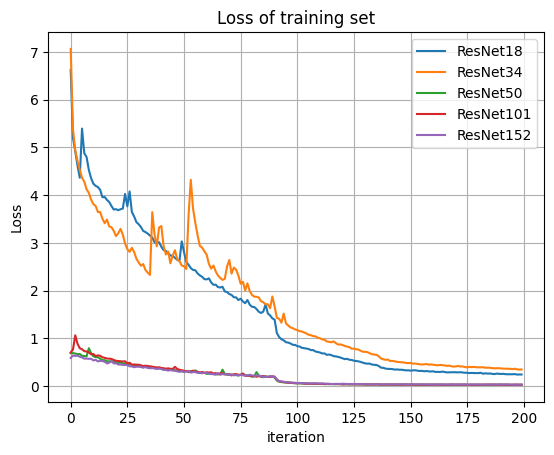

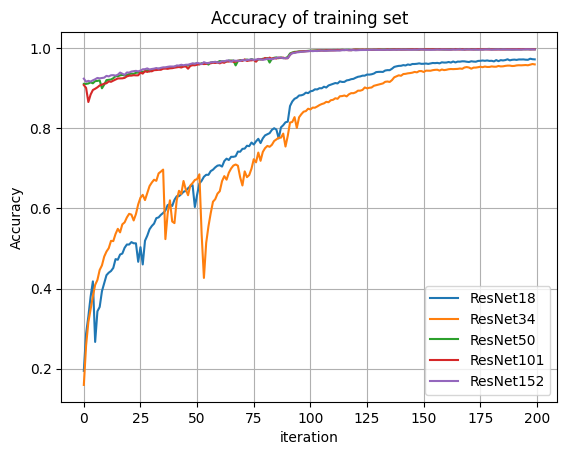

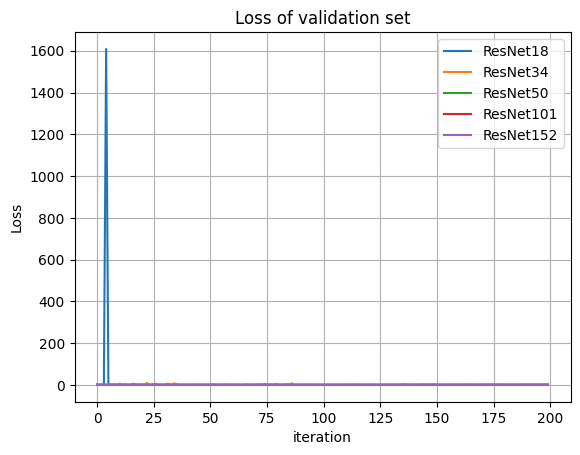

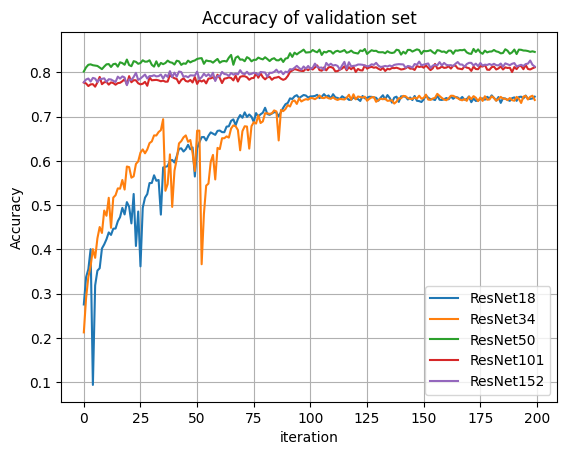

In [6]:
# plot the loss figure and the accuracy figure
import matplotlib.pyplot as plt
import numpy as np

# plot the training loss figure
net_depths = [18, 34, 50, 101, 152]

plt.title('Loss of training set')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.grid()

for i, loss in enumerate(training_losses):
    plt.plot(np.arange(len(loss)), loss, label=f'ResNet{net_depths[i]}')

plt.legend()
plt.show()

# plot the training accuracy figure
plt.title('Accuracy of training set')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.grid()

for i, accuracy in enumerate(training_accuracies):
    plt.plot(np.arange(len(accuracy)), accuracy, label=f'ResNet{net_depths[i]}')

plt.legend()
plt.show()

# plot the validation loss figure
plt.title('Loss of validation set')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.grid()

for i, loss in enumerate(validation_losses):
    plt.plot(np.arange(len(loss)), loss, label=f'ResNet{net_depths[i]}')

plt.legend()
plt.show()

# plot the validation accuracy figure
plt.title('Accuracy of validation set')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.grid()

for i, accuracy in enumerate(validation_accuracies):
    plt.plot(np.arange(len(accuracy)), accuracy, label=f'ResNet{net_depths[i]}')

plt.legend()
plt.show()